In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The Plan

* Explore and visualize a dataset 
* Use K-nearest-neighbors for density estimation on 2D slices of data
* Use K-nearest-neighbors for density estimation on 4D data

## The Data

The fisher iris data is hosted online by [UC Irvine](http://archive.ics.uci.edu/ml/datasets/Iris). I prefer to download a local copy and use that, so in the next cell we check if the data exists locally and then download it if neaded. 

In [13]:
IRIS_DATA_PATH = 'bezdekIris.data'
IRIS_DATA_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data'

In [14]:
import os
from urllib.request import urlopen

if not os.path.isfile(IRIS_DATA_PATH):
    print("Downloading data.")
    open(IRIS_DATA_PATH, 'wb').write(urlopen(IRIS_DATA_URL).read())
else:
    print("Found a local copy of the data (yay!)")

Found a local copy of the data (yay!)


The dataset is stored using 'comma-separated values' (CSV). This data format is comonly used for design matrices because it can be easily read and edited by humans and machines. In fact you can open this file in most spreadsheet sofware. 

Let's look at the data. I will use [pandas](http://pandas.pydata.org/) to read and display the CSV file. 
> **NOTE:** Many people swear by pandas, but I myself use it only occationally. You should feel free to explore it and let me know if I am missing out on useful features. I am using pandas now because it displays tables nicely in jupyter and it sniffs out the datatype of each column. Python has other libraries for parsing CSV as well, please do explore on your own.

In [18]:
import pandas
df = pandas.read_csv(IRIS_DATA_PATH,
                     names=['sepal length', 
                            'sepal width', 
                            'petal length', 
                            'petal width', 
                            'species'])
df

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


Let's use the terminology of the book; the last column is the thing we want to predict (the flower species). The remaining columns are the data.
> **NOTE:** 
> * Our data is currently in a `pandas` `DataFrame` object, which was returned by the `read_csv` function above. This special object allows you to access rows and columsn of data by their names rather than their index. 
> * The `as_matrix()` method converts from a `DataFrame` into a `numpy` array, which is what I usually work with. 

In [21]:
targets = df.loc[:, 'species'].values
data = df.loc[:,'sepal length':'petal width'].values

Let's do some 2D plots of the data, but first I need to remind myself of the class names...

In [23]:
print(unique(targets))

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


I am going to create a boolean mask for each class. In the first three lines below, the `==` operator does the comparison for each array element and returns an array of booleans. I can pass the array in just like it was an index in order to filter out rows of data for plotting. 

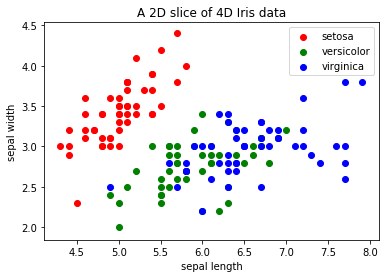

In [24]:
setosa = targets=='Iris-setosa'
versicolor = targets=='Iris-versicolor'
virginica = targets=='Iris-virginica'

scatter(data[setosa,0], data[setosa,1], color='red', label='setosa');
scatter(data[versicolor,0], data[versicolor,1], color='green', label='versicolor');
scatter(data[virginica,0], data[virginica,1], color='blue', label='virginica');

xlabel(df.columns[0])
ylabel(df.columns[1])
legend(loc='upper right')

title('A 2D slice of 4D Iris data');

In the plot above, I used `label=` to assign labels to the scatter plots of each class. The labels are used by the `legend()` function to put a legend inthe plot. 

Note that this was only a single slice of the data. 
It is often useful to view the whole array of plots (even though almost half of them are redundant). In the cell below, I show a scatter plot for each pair of features. Along the diagonals (where the x and y axises would be the same), I instead plot histograms.

It is often useful to view the whole array of plots (even though almost half of them are redundant). In the cell below, I show a scatter plot for each pair of features. Along the diagonals (where the x and y axises would be the same), I instead plot histograms.

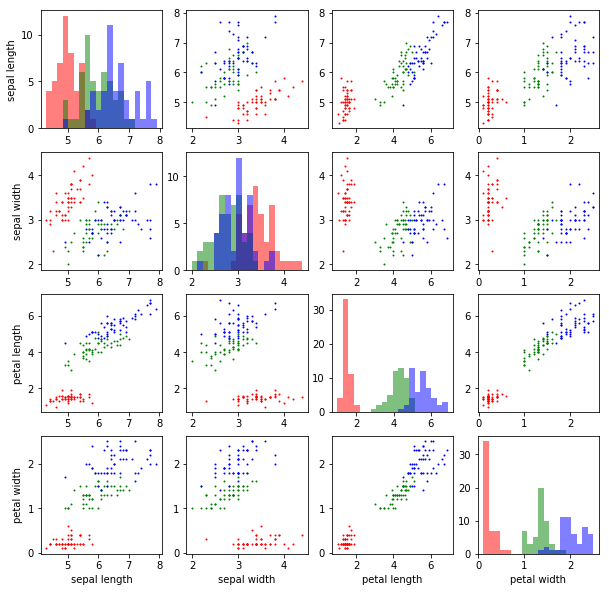

In [25]:
fig, axes = subplots(4, 4)
fig.set_size_inches(10,10)
for i in range(4):
    axes[-1, i].set_xlabel(df.columns[i])
    axes[i,  0].set_ylabel(df.columns[i])

for row in range(4):
    for col in range(4):
        sca(axes[row, col]) # Send all plotting instructions to the current subplot
        if row == col:
            vmin=data[:,col].min()
            vmax=data[:,col].max()
            hist(data[setosa,col], bins=20, range=(vmin,vmax), color='red', histtype='stepfilled', alpha=0.5)
            hist(data[versicolor,col], bins=20, range=(vmin,vmax), color='green', histtype='stepfilled', alpha=0.5)
            hist(data[virginica,col], bins=20, range=(vmin,vmax), color='blue', histtype='stepfilled', alpha=0.5)
        else:
            scatter(data[setosa,col], data[setosa,row], color='red', s=1, label='setosa');
            scatter(data[versicolor,col], data[versicolor,row], color='green', s=1, label='versicolor');
            scatter(data[virginica,col], data[virginica,row], color='blue', s=1, label='virginica');

Unfortunately it is hard t wrap our brains around 4D data, but this kind of plot is a useful way to think of things. 

> **NOTE:** There is one kind of error that is _extremely_ annoying -- rounding error. In this case, you can see that the points seem to lie along points in a grid.  It is unlikely that the original data had this pattern, so we might actually produce a sample that is _**more**_ true to the underlying model for flowers by adding a small perturbation to the data. 

In [26]:
data = df.loc[:,'sepal length':'petal width'].values + uniform(-0.05, 0.05, size=data.shape)

Now that the quantization "noise" has been replaced by the uniformly distributed 'jitter' we applied to the data. 

Nother huge benefit is that it is no longer as likely that two points occupy the exact same location. This helps with some numerical algorithms one might apply to the data as well as making the visualization more plausible. 

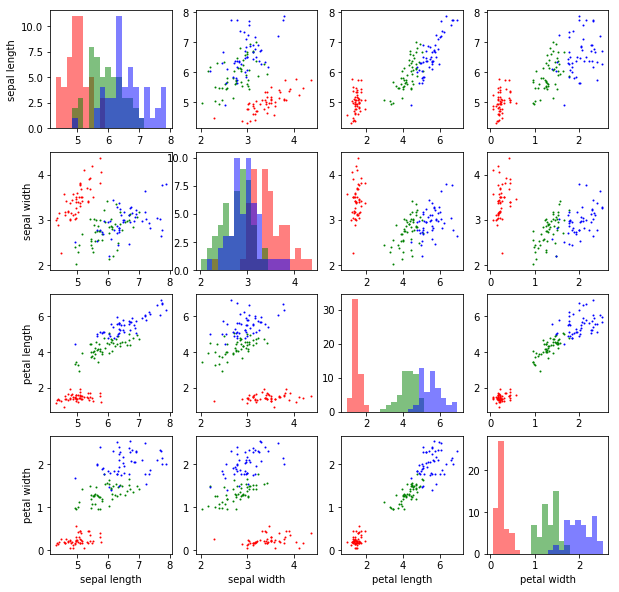

In [27]:
fig, axes = subplots(4, 4)
fig.set_size_inches(10,10)
for i in range(4):
    axes[-1, i].set_xlabel(df.columns[i])
    axes[i,  0].set_ylabel(df.columns[i])

for row in range(4):
    for col in range(4):
        sca(axes[row, col]) # Send all plotting instructions to the current subplot
        if row == col:
            vmin=data[:,col].min()
            vmax=data[:,col].max()
            hist(data[setosa,col], bins=20, range=(vmin,vmax), color='red', histtype='stepfilled', alpha=0.5)
            hist(data[versicolor,col], bins=20, range=(vmin,vmax), color='green', histtype='stepfilled', alpha=0.5)
            hist(data[virginica,col], bins=20, range=(vmin,vmax), color='blue', histtype='stepfilled', alpha=0.5)
        else:
            scatter(data[setosa,col], data[setosa,row], color='red', s=1, label='setosa');
            scatter(data[versicolor,col], data[versicolor,row], color='green', s=1, label='versicolor');
            scatter(data[virginica,col], data[virginica,row], color='blue', s=1, label='virginica');

# Kernel Density Estimation using Parzen Windows
The _kernel_ density estimation approach is a nonparametric way to estimate a (pseudo) probability density function. We will use it to estimate the probability of seing a sample given some attributes.

The key idea of a _kernel_ desnity estimate is approximate the probability density at test point $\mathbf{x}$  by counting the fraction of points that fall within a small region (a _Parzen window_) centered on $\mathbf{x}$.  In order to do this, one needs an efficient way to collect all points within some radius $r$ of a central point $\mathbf{x}$.  

One could write a for-loop to search for the neighbors of any point, and for high-dimensional data that is about as good as we can get, assymptotically. However, we usually build some sort of spatial index data structure (e.g. a **tree**) for several reasons:
* Sometimes the data is low dimensional, or we can reduce the dimensionality using some transformation. For low dimensional datset KD-trees or similar data structures work well.
* Sometimes we can accept an _**approximate**_ nearest neighbor search, in which case efficient randomized data structures can be fit to our data to make searching fast even for high dimensional data.

The next cell uses the nearest neighbor data structure that ships with `sklearn`, however you will find some others online that specialize on huge out of core data, or date that needs to be updated frequently, etc. 

In [29]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()

For now, let's use a 2D subset of our data. We will pluck out columns 0 ('sepal length') and 2 ('petal length'). 

In [30]:
x = data[:, (0, 2)]

I want to be able to test how well we estimate the density, so I will split our dataset into a training set (`x_train, y_train`) and a testing set (`x_test, y_test`). I could do this myself in just a few lines, but in this case it is clearer to use a function from `sklearn`.

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, targets)

In [34]:
print("training data shape:", x_train.shape)
print("test data shape:", x_test.shape)

training data shape: (112, 2)
test data shape: (38, 2)


In [35]:
nn.fit(x_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

The `radius_neighbors` method takes in an array of $n$ samples along with the radius of a bounding sphere and returns a pair of lists; 
* A list of arrays that have the distance to each point with the regioncentered at each sample
* A list of arrays that have the indexes. 

In [36]:
dist, ind = nn.radius_neighbors(x_test, radius=0.5)

In order to make sure we understand the data, let's visualize it. 

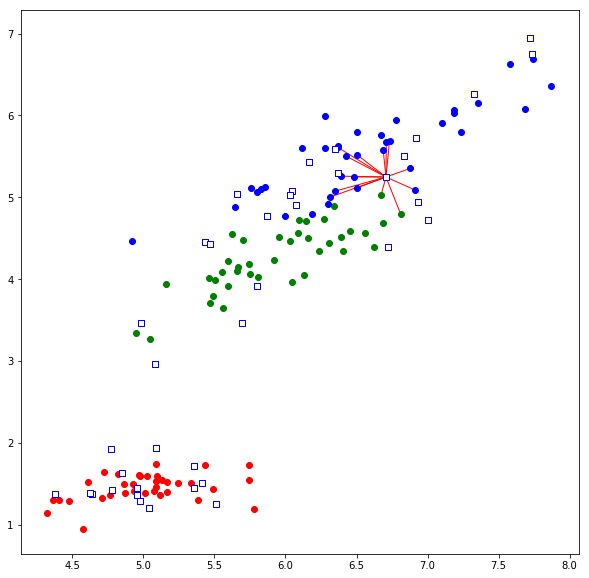

In [37]:
figsize(10,10)

# Determine which point to display
test_index = 34 # randint(len(x_test))

# Generate boolean masks for each class
setosa_train = y_train=='Iris-setosa'
versicolor_train = y_train=='Iris-versicolor'
virginica_train = y_train=='Iris-virginica'

# Show the training points
scatter(x_train[setosa_train, 0], x_train[setosa_train,1], color='red', zorder=1)
scatter(x_train[versicolor_train, 0], x_train[versicolor_train,1], color='green', zorder=1)
scatter(x_train[virginica_train, 0], x_train[virginica_train,1], color='blue', zorder=1)

# Show the test points
scatter(x_test[:,0], x_test[:,1], marker='s', edgecolor='blue', facecolor='white', zorder=2)

# Show the nearest neighbors to the test point at `test_index`
ax = gca()
for i in ind[test_index]:
    ax.add_line(Line2D([x_test[test_index,0], x_train[i,0]], 
                       [x_test[test_index,1], x_train[i,1]], 
                       color='red', 
                       linewidth=1, zorder=0))

We can approximately determine the density at each point by counting the number of times a sample occurs and dividing by the volume of the region. 

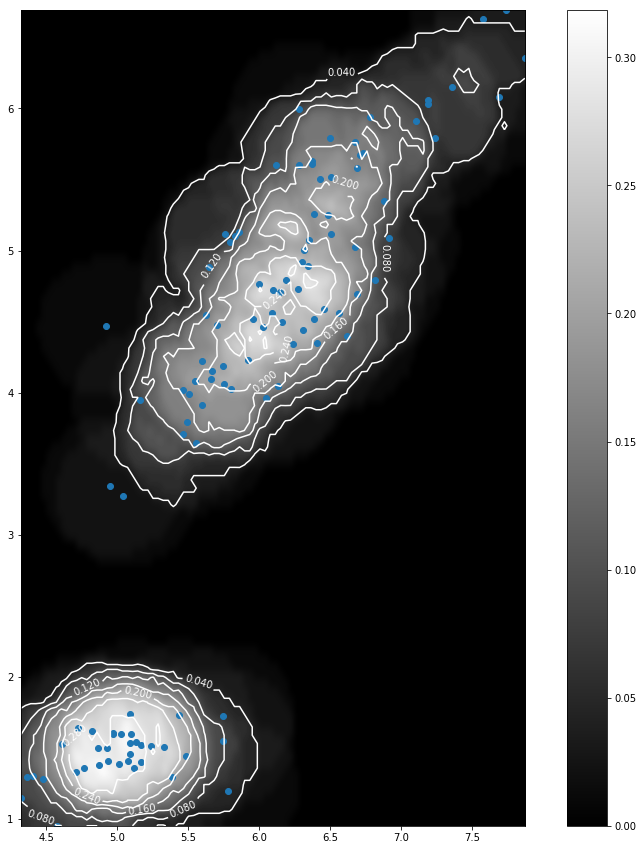

In [38]:
# Do not get confused by my abuse of 'y' --> here 'y' is the vertical axis of a plot
figsize(15, 15)
xmin, ymin = x_train.min(0)
xmax, ymax = x_train.max(0)
grid_y, grid_x = mgrid[ymin:ymax:100j, xmin:xmax:100j]
p = zeros((100,100))

r = 0.5
V = pi*r**2.
N = len(x_train)

for row in range(100):
    for col in range(100):
        x = [grid_x[row,col], grid_y[row,col]]
        distances, neighbors = nn.radius_neighbors(atleast_2d(x), radius=r)
        K = len(neighbors[0])
        p[row,col] = K/(N*V)
        
imshow(p, extent=(xmin,xmax, ymin, ymax), origin='lower', interpolation='bicubic', cmap=cm.gray)
colorbar()
scatter(x_train[:,0], x_train[:,1])
clabel(contour(grid_x, grid_y, p, colors='white'))
xlim(xmin, xmax)
ylim(ymin, ymax);

Notice that the shape of the window (in this case a disk) shows through. 

## Exercise
Replace the estimate of `p` above with a truncated Gaussian, that is use (2.250)  but only evaluate it for points that fall within a radius of $2h$
> **NOTE:** We are truncating the gaussian because points that are further away likely contribute less to the density at each point -- this allows os to save computeation at a cost in precision. Recall our discussion of the curse of dimensionality, for higher dimensional data we may need to use a larger radius

In [73]:
#TODO: Modify the cell above using (2.250). You will be using the `distances` array returned from `nn.radius_neighbors`

## Exercise

Follow the example of my last plot, but make two important changes:
* Use `nn.kneighbors` to get the _K=5 nearest neightbors_ instead of finding every neighbor within a disk. 
* find three conditional probabilities `p_setosa`, `p_versicolor` and `p_virginica` using (2.256).  Instead of plotting the density, plot colors similar to figure 2.28 of your book. 
> **HINT:** To display the colors you can use this trick:
> ```python
    labels = argmax([p_setosa, p_versicolor, p_virginica], 0)
    colors = array([[1.,0,0], [0,1.,0], [0,0,1.]])[labels]
    imshow(colors, extent=(xmin,xmax, ymin, ymax), origin='lower', alpha=0.5)
  ```
  What is happening is I am creating a palette of thre colors, 'red' (1,0,0), 'green', (0,1,0), and 'blue' (0,0,1). Then I am using the labels as indices, which will return a new array where the first dimensions are the same shape as `labels`, but the labels have been replaced by the corresponding color. 

In [ ]:
#TODO

## Exercise

So far, we have trained our `nn` classifier on only two features of our 4D data. The `sklearn` library already has a class that does most of the work we just did. Using the [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), train (fit) the model to `x_train` and `y_train`, and the evaluate (score) the testing data `x_test` and `y_test`.  Print the mean accuracy.

In [ ]:
#TODO

# Bonus Exercises

Assume that you called your classifier `classfier` in the previous exercise. The _mean accuracy_, returned by the `classifier.score(x_test, y_test)` method is usually not enough information about a classifier. 

* Use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) to see a breakdown of which classes you were able to discern well and which pairs of classes confuse your classifier. We can discuss this in class.
* Use [sklearn.metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) to print a more detailed breakdown of the classifiers performance. We can discuss the meaining of these metrics in class. 

In [ ]:
#TODO